# Survey of Numerical Methods for Orbit Determination Problems.

In [11]:
%matplotlib inline
import cProfile, pstats, StringIO
import numpy
import numpy as np
import matplotlib.pyplot as plt

## Introduction
Orbit Determination (OD) consists in methods of determining the position and velocity (i.e., the state vector) of a system of orbiting objects. Numerical methods are extremely important for Orbit Determination, specifically for the well known N-Body Problem, for which an analytical solution cannot be found, and numerical approximations must be used for systems with N > 2. 

Solving the N-body problem can be viewed as two parts: 1) calculating the net force on a given particle at a given time (in this scope, neglecting other forces but gravity), and 2) determine the position and velocity at some point in the future time. 

This project will describe and implement two different numerical methods for orbit propagation for 2-body and 3-body problems. The implicit Runge-Kutta Gauss-Legendre method will be compared to the fourth-order explicit Runge Kutta method. The results will then be compared with the analytical solution for the 2-body problem. Explicit Runge-Kutta been studied for more that 100 years, but implicit Runge-Kutta methods with different integration quadrature rules have been developed in the last 50 years.

> "Gauss-Legendre methods are the Lamborghinis of the numerical ODE world. They are expensive and hard to drive, but they have style!"

Equations of motion for orbits are very stiff due to their nonlinear differential nature and eccentricity. Any small change in the initial conditions can virtually lead to a completely different orbit. Implicit methods, due to their A-stability properties, will work better than explicit methods for large time steps and long running simulations. We expect that the implicit Runge-Kutta Gauss-Legendre method does not blow up, but for large time steps will not be accurate. The explicit Runge-Kutta method will be stable for smaller time steps, but is much easier to implement and faster to run. Both will converge to the true solution if the time step is small enough.

## The N-Body Problem
Consider N point masses in $\mathcal{R}^3$, where the only force acting on them is their mutual gravitational attraction. For the *i* th element, we have:  
$q_i$: position vector  
$p_i$: velocity vector  

The state vector of an orbiting particle is composed of a set of position and velocity components, usually defined in a Cartesian reference frame, normally reference to the heaviest particle's center of mass. Newton's second law says that mass times acceleration of the *i*th particle is equal to the sum of the forces acting on the particle.  
$$
\require{asmath}
\ddot{q_i} = \frac{\partial^2 q_i}{\partial t^2} = \text{acceleration}\\
\begin{equation}
m_i\ddot{q_i} = \sum \text{forces acting on i-th particle}
\end{equation}
$$  
Newton's law of gravity says the magnitude of force on particle *i* due to particle *j* is proportional to product of their masses and inversely proportional to square of distance between them. The direction of this force is along the unit vector from *i* to *j*.  

$$
\begin{equation}
f_i = \frac{Gm_im_j}{\Vert q_i - q_j\Vert^2} \frac{(q_j - q_i)}{\Vert q_i - q_j \Vert}
\end{equation}
$$  
Putting (1) and (2) together, we get:

$$
m_i\ddot{q_i} = \sum_{j=1,j \neq i}^{N} \frac{Gm_im_j(q_j - q_i)}{\Vert q_i - q_j \Vert^3}
$$

Let $U = \sum_{j=1,j \neq i}^{N} \frac{Gm_im_j}{\Vert q_i - q_j \Vert}$ called the *self-potential (potential energy)* and find $\frac{\partial U}{\partial q_i}$. We know that $\Vert u \Vert = \sqrt{u^2}$. Let $u = (q_i - q_j)$ and:  

$$
U = \sum_{j=1,j \neq i}^{N} \frac{Gm_im_j}{\sqrt{u^2}}\\
\text{Using chain rule } \frac{\partial U}{\partial q_i} = \frac{\partial U}{\partial u}\frac{\partial u}{\partial q_i}\\
$$
Let $a = u^2$ and use chain rule again.  

$$
\frac{\partial U}{\partial u} = \frac{\partial U}{\partial a}\frac{\partial a}{\partial u} \\
= \frac{\partial}{\partial a}\left(\sum_{j=1,j \neq i}^{N} \frac{Gm_im_j}{\sqrt{a}} \right) 2u 
= -\frac{1}{2}\sum_{j=1,j \neq i}^{N} Gm_im_ja^{\frac{3}{2}} 2u = -\sum_{j=1,j \neq i}^{N} Gm_im_j \frac{u}{a^{\frac 3 2}}\\
$$  
Substitute back $a = u^2$  

$$
\frac{\partial U}{\partial u} = -\sum_{j=1,j \neq i}^{N} Gm_im_j \frac{u}{(u^2)^{\frac 3 2}} 
= -\sum_{j=1,j \neq i}^{N} Gm_im_j \frac{u}{((u^2)^{\frac 1 2})^3}\\
$$  
Substitute back $u = q_i - q_j$: 

$$
\frac{\partial U}{\partial u} = -\sum_{j=1,j \neq i}^{N} Gm_im_j \frac{u}{\sqrt{u^2}^3} 
= \sum_{j=1,j \neq i}^{N} Gm_im_j \frac{q_j - q_i}{\Vert q_i - q_j \Vert^3}
$$  
Having $\frac{\partial u}{\partial q_i} = 1$ we conclude that:  

$$
\frac{\partial U}{\partial q_i} = \sum_{j=1,j \neq i}^{N} \frac{Gm_im_j(q_j - q_i)}{\Vert q_i - q_j \Vert^3} = m_i\ddot{q_i}
$$  
The momentum of the particle *i* is defined by $p_i = m_i\dot{q_i}$. The equations of motion become:
$$
q_i = \frac{p_i}{m_i} = \frac{\partial H}{\partial p_i} \qquad p_i = \sum_{j=1, j\neq 1}^{N} Gm_im_j \frac{q_j - q_i}{\Vert q_i - q_j \Vert^3} = -\frac{\partial H}{\partial q_i}
$$  
Where $H$ i called the *Hamiltonian* and is defined by:  

$$
H = T - U
$$  
Where $T$ is the kinetic energy and U as defined in (4)
$$
T = \frac 1 2 \sum_{i=1}^{N} m_i \Vert \dot{q_i} \Vert^2
$$
We get a system of coupled, first order ODES. The conjugate of postition $q$ is momentum $p$.
Another way to write the system as a set of coupled first order ODEs is:  

$$
\frac{d}{dt}
\begin{bmatrix}
    q_i\\
    p_i\\
\end{bmatrix} =
\begin{bmatrix}
    p_i\\
    \sum_{j=1, j\neq 1}^{N} Gm_j \frac{q_j - q_i}{\Vert q_i - q_j \Vert^3} \\
\end{bmatrix}
$$  
Since $q_i$ and $p_i$ are in reference system $\mathcal{R}^3$, we have a set of $6N$ first order equations, needing $6N$ initial conditions.
Now, let $L = p_1 + p_2 + \ldots + p_N$ be the total linear momentum of the system. From (5) we can see that $\dot{L} = 0$ since each term in the sum apperars twice with opposite sign (because of $q_j - q_i$ term). That means the total linear momentum $L$ is constant.  

Let $A = q_1 \times p_1 + q_2 \times p_2 + \ldots + q_N \times p_N$ be the total angular momentum of the system. Then:  

$$
\dot{A} = \sum_{i=1}^{N} (\dot{q_i} \times p_i + q_i \times \dot{p_i})\\
\qquad = \sum_{i=1}^{N} \frac{p_i}{m_i} \times p_i + \sum_{i=1}^{N}\sum_{j=1, j\neq 1}^{N} \frac{Gm_im_jq_i \times (q_j - q_i)}{\Vert q_i - q_j \Vert^3}
$$  
The first sum is zero, because $p_i \times p_i = 0$. In the second sum, we have $q_i \times q_i = 0$, and then we have $q_i \times q_j$, but each term will appear twisce with opposite sign. Thus, the angular momentum $A$ also remains constant. 

This system is non-linear because of its dependence on $\Vert q_i - q_j \Vert^2$, which means that a slight change on the initial conditions can lead to a completely different behavior in the long term, make the N-body problem very **stiff**. Since this is a conservative system, we need global conservation of energy (potential and kinetic) and angular momentum.  

## 2-Body Problem
In general, is believed that for $N \gt 2$, the N-body problem do not have an analytical solution.
For the 2-body problem, we consider a very massive particle with fixed position (can be the origin of reference system in $\mathcal{R}^3$); and other particle with mass $m_1$. The N-body problem becomes a Kepler problem, where the equations of motion for particle $1$ become:
$$  
\ddot{q} = -\frac{\mu q}{\Vert q \Vert^3} \qquad p = \dot{q}\\
\text{Where } \mu = G(m_1 + m_2) \text{. This system becomes Hamiltonian with }\\
H = \frac{\Vert p \Vert^2}{2} - \frac{\mu}{\Vert q \Vert}
$$  
From (5.1), angular momentum $A = q \times p$ which is know is constant along the solution:  

$$
\frac{d}{dt}\frac{q}{\Vert q \Vert} = \frac{(q \times \dot{q}) \times q}{\Vert q \Vert^3} = \frac{A \times q}{\Vert q \Vert^3}\\
\text {Multiplying by } -\mu \text{ at both sides, we get: }\\
-\mu \frac{d}{dt}\frac{q}{\Vert q \Vert} = A \times -\frac{\mu q}{\Vert q \Vert^3} = A \times \dot{p}\\
$$  
Integrating (8) we get:  

$$
\mu\left(e + \frac{q}{\Vert q \Vert} \right) = p \times A
$$  
Where $e$ is a vector integration constant. Taking the dot product with $q$ at both sides:  

$$
\mu\left(e \cdot q + \frac{q \cdot q}{\Vert q \Vert} \right) = a \cdot p \times A\\
\qquad = \mu(e \cdot q + \Vert q \Vert) = q \times p \cdot A = A \cdot A = c^2
$$  
Being $c$ the magnitude of the angular momentum $A$. 

$$
e \cdot q + \Vert q \Vert = \frac{c^2}{\mu}
$$  
$e$ is called the *eccentricity vector* with magnitude $\epsilon = \Vert e \Vert$. If $e = 0$, the particle will move on a circle with uniform angular velocity because $\Vert q \Vert = \frac{c^2}{\mu} = \text{ constant }$.  

For the analytic solution of 2-body problem, consider the following orbital elements:  
$e = \frac{p \times A}{\mu} - \frac{q}{\Vert q \Vert}$: eccentricity vector  

$\epsilon = \Vert e \Vert$: magnitude of the eccentricity vector  

$g$: argument of perigee, angle from $q_1$ axis to $e$  

$\theta$: position angle in polar coordinates  

$f = \theta - g$: true anomaly  

$r$: position vector in polar coordinates (assuming the motion is co-planar)  

Using this orbital elements, equation (9) becomes:  

$$
r = \frac{\frac{c^2}{\mu}}{1 + \epsilon cos(f)}
$$  
Since the LHS of the system des not explicitly depends on time, we need to introduce the *mean anomaly M*, which is related to the *mean motion n* over time as following:  

$$
M(t) = M(t_0) + n(t - t_0)
$$  
While the mean motion $n$ is a measure of radians per unit time:  

$$
n = \sqrt{\frac{mu}{a^3}}
$$  
Where $a$ is the semi-major axis of the trajectory.  
Kepler's equation for the Mean Anomaly tells us how to calculate $M$ given eccentricity $e$ and eccentricity anomaly $E$  

$$
M = E - esin(E)
$$  
We need to solve for E to calculate true anomaly at each time step, but this equation is not invertible in terms of $E$. We need to solve for $E$ algoritmically.  We present next the algorithm we will follow to find the true solution over time for the 2-body problem.  

---
#### Algorithm for the 2-Body Problem
---
* From the initial conditions, find the following orbital elements:  

    $A = q \times p$  

    $e = \frac{p \times A}{\mu} - \frac{q}{\Vert q \Vert}$  

    $a = \frac{\Vert A \Vert}{\mu(1 - \Vert e \Vert^2)}$   
    
    $g = acos\left(q_1 \cdot \frac{e}{\Vert e \Vert} \right)$  
    
    $f = acos\left(\frac{e}{\Vert e \Vert} \cdot \frac{q}{\Vert q \Vert} \right)$  
    
    $\theta = f - g$  
    
    $n = \sqrt{\frac{\mu}{a^3}}$  
    
    $E_0 = acos(cosh(f))$  
    
    $M_0 = E - esin(E)$  


* For each time step, calculate:  

    $M = M_0 + n(t - t_0)$  
    

* Solve for new $E$ using $M - esin(E)$. For this step, we will use Newton-Raphson iterator. Given an initial guess for $E$, we use the Newton-Raphson iterator until the difference between steps becomes very small.  

    $E_{new} = E_{old} - \frac{E_{old} - (M + esin(E_{old}))}{1 - ecos(E_{old})}$  

    __if__ $|E_{old} - E_{new}| \ll$ tolerance  
    &nbsp;&nbsp;&nbsp;&nbsp;__break__
        
* Determine the new true anomaly, position vector and angle using:  

    $r = a(1 - \Vert e \Vert cos(E))$

---


In [2]:
"""
Implementation of Analytical Solution for 2-Body Problem
"""
def two_body_problem(q, p, mu, t):
    """
    Parameters:
        q, p: initial conditions for position and velocity
        mu: G*m, being m the mass of heavy particle
        t: time vector
    Output:
        Q: state vector for position (x, y components)
        P: state vector for velocity (x, y components)
    """
    #Angular momentum and magnitude
    A = numpy.cross(q, p)
    c = numpy.linalg.norm(A)

    #Eccentricity and magnitude
    e = numpy.cross(p, A) / mu - q / numpy.linalg.norm(q)
    epsilon = numpy.linalg.norm(e)

    #Semi-major axis
    a = c**2/(mu*(1 - epsilon**2))

    #Argument of perigee - angle between positive axis and e
    g = numpy.arccos(numpy.dot([1.0, 0.0, 0.0], e / epsilon))
    #True anomaly
    f = numpy.arccos(numpy.dot(e / epsilon, q / numpy.linalg.norm(q)))
    theta = f - g

    #Mean motion, radians per second
    n = numpy.sqrt(mu/a**3)
    #Eccentric anomaly
    E0 = numpy.arccos(numpy.cosh(f))
    #Mean anomaly
    M0 = E0 - epsilon*numpy.sin(E0)
    
    Q = numpy.zeros((3, t.shape[0]))
    P = numpy.zeros((3, t.shape[0]))
    Q[:, 0] = q
    P[:, 0] = p
    for i in xrange(1, t.shape[0]):
        #Time behavior of Mean Anomaly
        M = M0 + n*t[i]
        #Initial guess for Eccentricity Anomaly
        E_old = M - epsilon if M > 0 else M + epsilon
        tolerance = 1.0
        #Solve for E using a Newton-Raphson iterator
        while tolerance > 10e-10:
            E = E_old - (E_old - (M + epsilon*numpy.sin(E_old)))/(1.0 - epsilon*numpy.cos(E_old))
            tolerance = numpy.abs(E - E_old)
            E_old = E

        r = a*(1 - epsilon*numpy.cos(E))
        f = 2.0*numpy.arctan(numpy.sqrt((1.0 + epsilon)/(1.0 - epsilon))*numpy.tan(E/2.0))
        theta = f - g
        
        #Transform from perifocal to inertial system
        q_x = r*numpy.cos(theta)
        q_y = r*numpy.sin(theta)
        Q[:, i] = q_x, q_y, 0.0
        
        v_r = mu*epsilon*numpy.sin(f) / c
        v_t = c / r
        v_x = v_r*numpy.cos(theta) - v_t*numpy.sin(theta)
        v_y = v_r*numpy.sin(theta) + v_t*numpy.cos(theta)
        P[:, i] = v_x, v_y, 0.0
    
    return Q, P

In [3]:
"""
Right-hand side function for the 2-Body Problem
"""
def rhs_two_body(t, U):
    """
    Parameters:
        t: time vector
        U: state matrix for satellite motion
    Returns:
        f_U: evaluation of RHS
    """
    r = U[0:3]
    v = U[3:6]
    mu = 3.986004415*10**5
    
    dr = v
    dv = -mu*r/(numpy.linalg.norm(r)**3)

    f_U = numpy.zeros(6)
    f_U[0:3] = dr
    f_U[3:6] = dv
    
    return f_U

## Numerical Methods for the N-Body Problem

### Explicit Runge-Kutta
We have already considered an autonomous 3-dimensional initial value problem in the form:  

$$
\dot{u(t)} = f(u(t)) \qquad u(t_0) = u_0 \qquad f: \mathcal{R}^3 \rightarrow \mathcal{R}^3
$$  

The simple Euler method:
$$
U_n = U_{n-1} + \Delta t f(U_{n-1})
$$  
can be made more accurate by using mid-point or trapezoidal rule quadrature for integration of f:  

$$
U_n = U_{n-1} + \Delta t f(U_{n-1} + \frac 1 2 \Delta t f(U_{n-1}))\\
U_n = U_{n-1} + \frac 1 2 \Delta t f(U_{n-1}) + \frac 1 2 \Delta t f(U_{n-1} + \Delta t f(U_{n-1}))
$$  
This methods are second order accurate, i.e., error term behaves as $\mathcal{O}^3$. The leading term for local truncation error goes as $\mathcal{O}^2$.  

Runge-Kutta methods try to find higher order explicit methods. In these methods, we evaluate *s* stage values $U_i$ and *s* stage derivatives $F_i$.  

$$
U_i = U_n + \Delta t \sum_{j=1}^s a_{ij}F_j \approx u(t_n + c_i\Delta t)
$$  
And the approximate solution is:  

$$
U_{n+1} = U_n + \Delta t \sum_{j=1}^s b_i F_i \approx u(t_n + \Delta t)
$$  
We can represent the family of Runge-Kutta methods using the well-known Butcher table:  

|    c1    | a11 | a12 | $\dots$ |    a1s   |
|:--------:|:---:|:---:|:-------:|:--------:|
|    c2    | a21 | a22 | $\dots$ |    a2s   |
| $\vdots$ |     |     |         | $\vdots$ |
|    cs    | as1 | as2 | $\dots$ |    ass   |
|          |  b1 |  b2 | $\dots$ |    bs    |

It must be satisfied that $c_i = \sum_{j=1}^s a_{ij}$  

The method is explicit if $c_1 = 0$ and $a_ij = 0 \quad \forall i \geq j$, omitting from matrix A the lower triangular and the diagonal. A semiexplicit mehtod occurs when $a_ij = 0 \quad \forall i \gt j$, where A becomes lower triangular.  

The coefficients for th he 4-stage Explicit Runge-Kutta method is given by:

| 0   |     |     |     |     |
|-----|-----|-----|-----|-----|
| 1/2 | 1/2 |     |     |     |
| 1/2 |     | 1/2 |     |     |
| 1   |     |     | 1   |     |
|     | 1/6 | 2/6 | 2/6 | 1/6 |

The method is implemented as follows
$$\begin{aligned}
&k_1& &= f(t_i, u_i) \\
&k_2& &= f(t_i + \frac{\Delta t}{2}, u_i + \frac{\Delta t}{2}k_1) \\
&k_3& &= f(t_i + \frac{\Delta t}{2}, u_i + \frac{\Delta t}{2}k_2) \\
&k_4& &= f(t_i + \Delta t, u_i + \Delta t k_3) \\ \\
&U^{n+1}& &= U^n + \frac{\Delta t}{6}\left(k_1 + 2k_2 + 2k_3 + k_4 \right)
\end{aligned}$$  

This is obviously explicit since each $k_i$ only depends on the previously computed $k_j$ and the matrix A is a lower diagonal with diagonal omitted.

In [4]:
"""
Implementation of Explicit Runge-Kutta with 4 stages, using RHS for 2-body problem
"""
def ERK4_2B(t, q, p):
    """
    Parameters:
        t: time vector
        q, p: initial conditions for position and velocity
    Returns:
        U: state vector
    """
    U = numpy.zeros((6, t.shape[0]))
    delta_t = t[1] - t[0]
    U[0:3, 0] = q
    U[3:6, 0] = p

    for i in xrange(t.shape[0] - 1):
        k1 = delta_t*rhs_two_body(t, U[:,i])
        k2 = delta_t*rhs_two_body(t + delta_t/2.0, U[:,i] + k1/2.0)
        k3 = delta_t*rhs_two_body(t + delta_t/2.0, U[:,i] + k2/2.0)
        k4 = delta_t*rhs_two_body(t + delta_t, U[:,i] + k3)

        #Step forward in time
        U[:,i + 1] = U[:,i] + 1.0/6.0*(k1 + 2.0*k2 + 2.0*k3 + k4)
    
    return U

### Implicit Runge-Kutta
An implicit Runge-Kutta method present advantages in terms of absolute stability, being more suitable for stiff problems. For our purpose, using the Gauss-Legendre quadrature as integrator leads to GL-IRK method.  

When the Gauss-Legendre quadrature rule is used for an implicit Runge-Kutta method, we reach an order of accuracy of *2s*, which is the best we can do with this family of methods.  

The coefficients $c_i$ are chosen as the zeros od the Legendre Polynomial of degree s: $\mathcal{P}_s(2x - 1)$. The $b_i$s are chosen from the quadrature formula:  

$$
\int_{0}^1 \phi(x)dx \approx \sum_{i=1}^s b_i \phi(c_i)
$$  

Where $\phi$ is a polynomial of degree less or equal than *s - 1*. Using the Lagrange interpolating polynomial to find the $b_i$s:

$$
\mathcal{L}_{ji}(x) = \prod_{j \neq i} \frac{x - x_i}{x_j - x_i} \qquad j=1, 2, \dots, s\\
b_j = \frac {1}{\Delta t} \int_{t}^{t + \Delta t} \mathcal{L}_{sj}(\tau) d\tau
$$  

Elements of A are also related to the quadrature formula in a $[0, c_i]$ interval:  

$$
a_{ij} = \int_{t}^{t + c_i\Delta t} \mathcal{L}_{sj}(\tau) d\tau
$$

We want $s=2$ to match the 4th-order accuracy of Explicit Runge-Kutta with 4 stages. This leads to:  

$$
\mathcal{P}_2(x) = \frac 1 2 \left(3x^2 - 1 \right) \rightarrow \mathcal{P}_2(2x -1) = \frac 1 2 \left(3(2x - 1)^2 - 1 \right)\\
\qquad = \frac 1 2 (12x^2 -12x + 2) = 6x^2 - 6x + 1\\
$$  
Roots of this polynomial are:  
$$
c_1 = \frac 1 2 - \frac{1}{2\sqrt{3}} = \frac 1 2 - \frac{\sqrt{3}}{6} \\
c_2 = \frac 1 2 + \frac{1}{2\sqrt{3}} = \frac 1 2 + \frac{\sqrt{3}}{6}
$$
For the $b_j$s we integrate:  
$$
b_1 = \frac {1}{\Delta t} \int_{t}^{t + \Delta t} \mathcal{L}_{21}(\tau) d\tau = \frac 1 2\\
b_2 = \frac {1}{\Delta t} \int_{t}^{t + \Delta t} \mathcal{L}_{22}(\tau) d\tau = \frac 1 2
$$

Similarly for coefficents of matrix A:  

$$
a_{11} = \frac {1}{\Delta t} \int_{t}^{t + c_1\Delta t} \mathcal{L}_{21}(\tau) d\tau =\frac 1 4\\
a_{12} = \frac {1}{\Delta t} \int_{t}^{t + c_2\Delta t} \mathcal{L}_{21}(\tau) d\tau =\frac 1 4 + \frac{\sqrt{3}}{6}\\
a_{21} = \frac {1}{\Delta t} \int_{t}^{t + c_1\Delta t} \mathcal{L}_{22}(\tau) d\tau =\frac 1 4 - \frac{\sqrt{3}}{6}\\
a_{22} = \frac {1}{\Delta t} \int_{t}^{t + c_2\Delta t} \mathcal{L}_{22}(\tau) d\tau =\frac 1 4\\
$$ 

For $s=2$, we need to calculate 2 stage values $u_1$ and $u_2$ and 2 right-hand side evaluations:
$$
u_1 = \Delta t f(t_i + c_1\Delta t, U_i + a_{11}u_1 + a_{12}u_2)\\
u_2 = \Delta t f(t_i + c_2\Delta t, U_i + a_{21}u_1 + a_{22}u_2)
$$  

This method is obviously implicit, because each stage evaluation depend on each other. We need to find the stage evaluations algoritmically, so that:  

---
#### Algorithm 2: Implicit RK stages
---
$u = 0$  
$u_{new} = \Delta t F(t_i, c_i, u, \Delta t)$  
__while__ max$(u - u_{new}) \gt$ tolerance  
&nbsp;&nbsp;&nbsp;&nbsp;recalculate stage values  

---

In [5]:
"""
Implementation of Implicit Runge-Kutta/Gauss-Legendre method for the 2-body problem
"""
def IRK_GL(t, q, p):
    """
    Parameters:
        t: time vector
        q, p: initial conditions for position and velocity
    Returns:
        U: state matrix
    """
    A = numpy.array([[1/4.0, 1/4.0 -1/6.0*numpy.sqrt(3)], 
                     [1/4.0+1/6.0*numpy.sqrt(3), 1/4.0]])
    b = numpy.array([[1/2.0], 
                     [1/2.0]])
    c = numpy.array([[1/2.0 - 1/6.0*numpy.sqrt(3.0)], 
                     [1/2.0 + 1/6.0*numpy.sqrt(3.0)]])
    
    #Initialize state matrix
    U = numpy.zeros((6, t.shape[0]))
    U[0:3, 0] = q
    U[3:6, 0] = p
    
    delta_t = t[1] - t[0]
    for i in xrange(t.shape[0] - 1):
        # Set stage function evaluations k1=0 and k2=0
        K = numpy.zeros((6, 2))
        D = numpy.dot(K, A.T)

        # Initial guess for k1 and k2
        K_new = numpy.zeros((6, 2))
        K_new[:, 0] = rhs_two_body(t + c[0]*delta_t, U[:,i] + delta_t*D[:, 0])
        K_new[:, 1] = rhs_two_body(t + c[1]*delta_t, U[:,i] + delta_t*D[:, 1])

        error = numpy.max(numpy.abs(K - K_new))
        tolerance = 1e-08

        # Calculate stage function evaluations
        while error > tolerance:
            K = K_new.copy()
            D = numpy.dot(K, A.T)
            K_new[:, 0] = rhs_two_body(t + c[0]*delta_t, U[:,i] + delta_t*D[:, 0])
            K_new[:, 1] = rhs_two_body(t + c[1]*delta_t, U[:,i] + delta_t*D[:, 1])
            error = numpy.max(numpy.abs(K - K_new))

        # Advance solution in time
        U[:,i+1] = U[:,i] + delta_t*numpy.dot(K_new, b).reshape(6)
    
    return U

## Error, Stability and Large Time Steps
In this section, we will use actual numerical data for a a high-altitude satellite and the Moon (data extracted from Satellite Calculations website, see references).

### 2-Body Problem: Earth-Satellite
Consider an Earth-centerd inertial frame, with Earth at fixed position. The satellite has the initial position and velocity:  

$$
q_{sat} = 
\left[\begin{matrix}
-98667.72518\\
-35912.11506\\
0.017307
\end{matrix}\right] km
\qquad
v_{sat} = 
\left[\begin{matrix}
0.868861\\
-2.387176\\
0.0
\end{matrix}\right] km/s
$$  

Since we don't have enough plot resolution to appreciate the error with respect to the true solution, we will use the true solution only to do error analysis numerically. We expect both methods to be fourth-order accurate, so is expected that the orbits generated by both explicit and implicit methods are very similar.

We use the infinity norm, that returns the the magnitude of the largest component of the error. Although both methods are 4-order accurate, IRK-GL shows better accuracy than RK4. For the velocity however, we can see that IRK-GL is one order of magnitude more accurate than RK4.

| Error RK4 vs Analytical | Error IRK-GL vs Analytical |
|-------------------------|----------------------------|
| 44.2576224214 km        | 10.5297604266 km           |
| 1.87686037723e-04 km/s  | 3.38023553742e-05 km/s     |

Error Explicit ERK: position 44.2576224214, velocity 0.000187686037723
Error Implicit IRK: position 10.5297604266, velocity 3.38023553742e-05


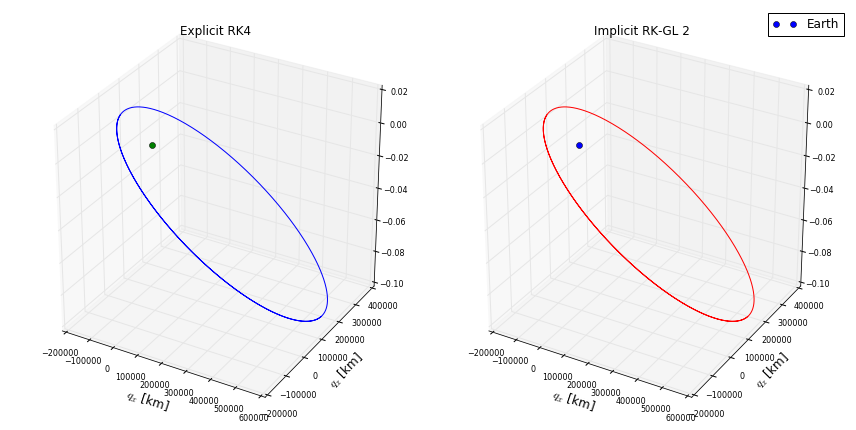

In [6]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['xtick.labelsize'] = 8

"""
Calculate trajectory for the satellite described above, using RK4, IRK-GL and compare
with the true solution obtained for the 2-Body Problem
"""

# Initial conditions
q = numpy.array((-98667.72518, -35912.11506, 0.017307))
p = numpy.array((0.868861, -2.387176, 0.0))
t = numpy.arange(0.0, 3000000.0, 1200.0)

# Gm_e
mu = 3.986004415*10**5

# Q and P return the components on the plane x, y
Q, P = two_body_problem(q, p, mu, t)

#Calculate RK4 for the 2-Body Problem
U_ERK2B = ERK4_2B(t, q, p)
#Calculate IRL-GL for the 2-Body Problem
U_IRK2B = IRK_GL(t, q, p)

# Error Analysis
eq_ERK2B = numpy.linalg.norm(U_ERK2B[0:2, :] - Q[0:2, :], ord=numpy.inf)
ep_ERK2B = numpy.linalg.norm(U_ERK2B[3:5, :] - P[0:2, :], ord=numpy.inf)
eq_IRK2B = numpy.linalg.norm(U_IRK2B[0:2, :] - Q[0:2, :], ord=numpy.inf)
ep_IRK2B = numpy.linalg.norm(U_IRK2B[3:5, :] - P[0:2, :], ord=numpy.inf)
print "Error Explicit ERK: position %s, velocity %s" % (eq_ERK2B, ep_ERK2B)
print "Error Implicit IRK: position %s, velocity %s" % (eq_IRK2B, ep_IRK2B)

fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(2, 2, 1, projection='3d')
axes.set_title("Explicit RK4")
axes.plot(U_ERK2B[0, :], U_ERK2B[1, :], U_ERK2B[2, :])
axes.plot([0], [0], [0], 'o')
axes.set_xlabel("$q_x$ [km]", fontsize=12)
axes.set_ylabel("$q_y$ [km]", fontsize=12)
axes.set_ylabel("$q_z$ [km]", fontsize=12)

axes = fig.add_subplot(2, 2, 2, projection='3d')
axes.set_title("Implicit RK-GL 2")
axes.plot(U_IRK2B[0, :], U_IRK2B[1, :], U_IRK2B[2, :], 'r')
axes.plot([0], [0], [0], 'o', label="Earth")
axes.set_xlabel("$q_x$ [km]", fontsize=12)
axes.set_ylabel("$q_y$ [km]", fontsize=12)
axes.set_ylabel("$q_z$ [km]", fontsize=12)
axes.legend()
plt.tight_layout()
plt.show()


For stability analysis, we want to see how both methods behave for large time steps. We want to increase time step until we find stability starts to fail. Starting with a time step of 36000 seconds (about 10 hours), explicit RK4 method starts to show a spiral orbit, finally blowing up at some point. However, the implicit Runge-Kutta Gauss-Legendre method still keeps up with the true solution, even for larger and larger time steps. Here is where we can appreciate the stability properties of the implicit method (A-stable). 

Near the periapse, the numerical method produces some wiggly results and jumps, while the analytical method appears to stay linear. It is problable that the numerical solution is affected but the close encounter at the periapse, and that it can get worse as the eccentricity is higher. In this case, the eccentriciy is $e = 0.7$

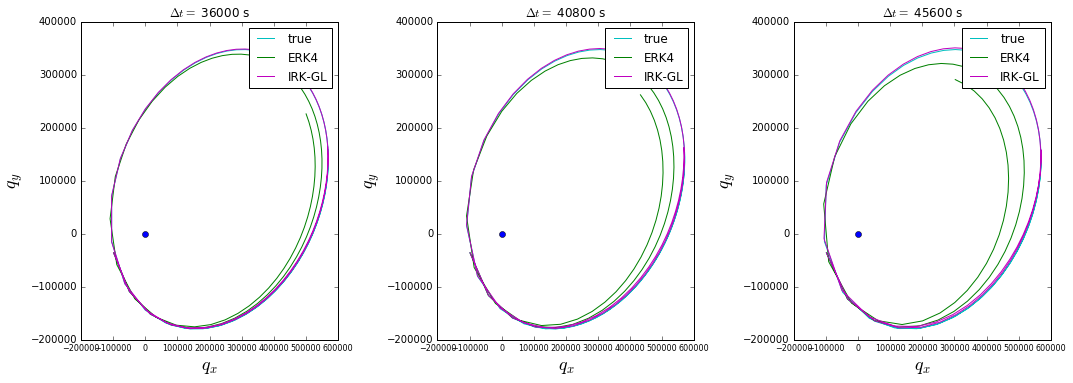

In [7]:
"""
Compare stability for large time steps
"""
# Initial conditions
q = numpy.array((-98667.72518, -35912.11506, 0.017307))
p = numpy.array((0.868861, -2.387176, 0.0))

fig = plt.figure(figsize=(15,15))
for i, delta_t in enumerate(numpy.arange(36000, 50400, 4800)):
    t = numpy.arange(0.0, 3000000.0, delta_t)
    Q, P = two_body_problem(q, p, mu, t)
    U_ERK2B = ERK4_2B(t, q, p)
    U_IRK2B = IRK_GL(t, q, p)
    
    axes = plt.subplot(3, 3, i + 1)
    axes.set_title("$\Delta t = $ %s s" % delta_t)
    axes.set_xlabel("$q_x$", fontsize=18)
    axes.set_ylabel("$q_y$", fontsize=18)
    axes.plot([0], [0], 'o')
    axes.plot(Q[0, :], Q[1, :], 'c', label='true')
    axes.plot(U_ERK2B[0, :], U_ERK2B[1, :], 'g', label='ERK4')
    axes.plot(U_IRK2B[0, :], U_IRK2B[1, :], 'm', label='IRK-GL')
    axes.legend()
    
plt.tight_layout()
plt.show()

### 3-Body Problem: Earth-Moon-Satellite
The study of a small mass in the gravitational field of two primary bodies is called restricted three-body problem or RTBP. In this section we will implement the elliptic restricted three-body problem (ER3BP), that requires that
the two objects (called the primaries, Earth and Moon) have their masses significantly larger than the third one (M1 >> M3 and M2 >> M3), and that the third mass (satellite) has no gravitational influence on the primaries.

For the 3 body problem, we want to generate first the Moon orbit using the respective numerical method for the 2-body problem, and then we will include this trajectory into the 3-body problem.

For trajectory comparison for the 3-Body Problem using a time step of 1200 seconds, both methods show very similar results. The discrepancies appear again when we increment the time step, in this case both solutions start to show erratic behavior until they both blow up. Implicit Runge-Kutta still have more stability than Explicit Runge-Rutta for the 3-Body Problem.


In [8]:
"""
Right-hand side 3-Body Problem: Earth (at the origin), Moon and satellite.
"""
def rhs_three_body(t, U, U_moon):
    """
    Parameters:
        t: time vector
        U: state matrix for satellite motion
        U_moon: state matrix for moon motion
    Returns:
        f_U: evaluation of RHS
    """
    r_sat = U[0:3]
    v_sat = U[3:6]
    
    r_moon = U_moon[0:3]
    v_moon = U_moon[3:6]

    mu_E = 3.986004415*10**5
    mu_M = 4902.799
    
    dr = v_sat
    dv = (- mu_E*r_sat/numpy.linalg.norm(r_sat)**3
          + mu_M*(r_moon - r_sat)/numpy.linalg.norm(r_sat - r_moon)**3)
              
    f_U = numpy.zeros(6)
    f_U[0:3] = dr
    f_U[3:6] = dv
    return f_U

In [9]:
"""
Runge-Kutta 4 method using 3-Body Problem RHS
"""
def ERK4_3B(t, q, p, U_3):
    """
    Parameters:
        t: time vector
        q, p: initial conditions for position and velocity
    Returns:
        U: state vector
    """
    U = numpy.zeros((6, t.shape[0]))
    delta_t = t[1] - t[0]
    U[0:3, 0] = q
    U[3:6, 0] = p

    for i in xrange(t.shape[0] - 1):
        k1 = delta_t*rhs_three_body(t, U[:,i], U_3[:, i])
        k2 = delta_t*rhs_three_body(t + delta_t/2.0, U[:,i] + k1/2.0, U_3[:, i])
        k3 = delta_t*rhs_three_body(t + delta_t/2.0, U[:,i] + k2/2.0, U_3[:, i])
        k4 = delta_t*rhs_three_body(t + delta_t, U[:,i] + k3, U_3[:, i])

        #Step forward in time
        U[:,i + 1] = U[:,i] + 1.0/6.0*(k1 + 2.0*k2 + 2.0*k3 + k4)
    
    return U

"""
Gauss-Legendre method using 3-Body Problem RHS
"""
def IRK_GL3B(t, q, p, U_3):
    """
    Parameters:
        t: time vector
        q, p: initial conditions for position and velocity
    Returns:
        U: state matrix
    """
    A = numpy.array([[1/4.0, 1/4.0 -1/6.0*numpy.sqrt(3)], 
                     [1/4.0+1/6.0*numpy.sqrt(3), 1/4.0]])
    b = numpy.array([[1/2.0], 
                     [1/2.0]])
    c = numpy.array([[1/2.0 - 1/6.0*numpy.sqrt(3.0)], 
                     [1/2.0 + 1/6.0*numpy.sqrt(3.0)]])
    
    #Initialize state matrix
    U = numpy.zeros((6, t.shape[0]))
    U[0:3, 0] = q
    U[3:6, 0] = p
    
    delta_t = t[1] - t[0]
    for i in xrange(t.shape[0] - 1):
        # Set stage function evaluations k1=0 and k2=0
        K = numpy.zeros((6, 2))
        D = numpy.dot(K, A.T)

        # Initial guess for k1 and k2
        K_new = numpy.zeros((6, 2))
        K_new[:, 0] = rhs_three_body(t + c[0]*delta_t, U[:,i] + delta_t*D[:, 0], U_3[:, i])
        K_new[:, 1] = rhs_three_body(t + c[1]*delta_t, U[:,i] + delta_t*D[:, 1], U_3[:, i])

        error = numpy.max(numpy.abs(K - K_new))
        tolerance = 1e-08

        # Calculate stage function evaluations
        while error > tolerance:
            K = K_new.copy()
            D = numpy.dot(K, A.T)
            K_new[:, 0] = rhs_three_body(t + c[0]*delta_t, U[:,i] + delta_t*D[:, 0], U_3[:, i])
            K_new[:, 1] = rhs_three_body(t + c[1]*delta_t, U[:,i] + delta_t*D[:, 1], U_3[:, i])
            error = numpy.max(numpy.abs(K - K_new))

        # Advance solution in time
        U[:,i+1] = U[:,i] + delta_t*numpy.dot(K_new, b).reshape(6)
    
    return U

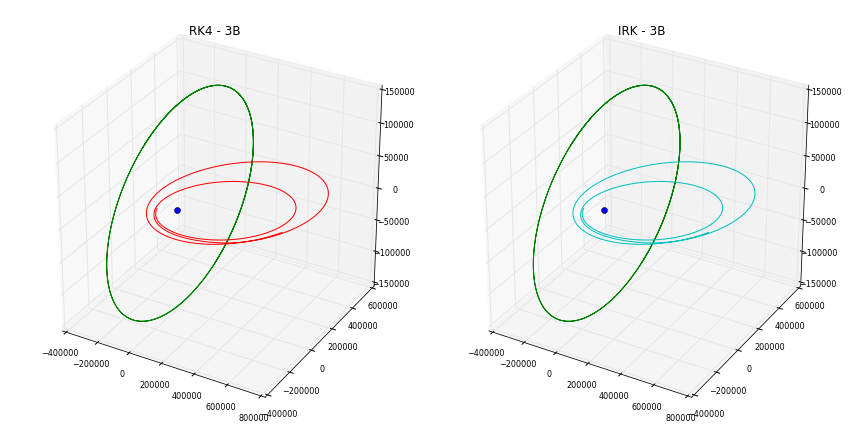

In [10]:
t = numpy.arange(0.0, 6000000.0, 1200.0)
# Build the Moon trajectory using the 2-Body method.
rm = numpy.array([339289.051438, -150932.215749, -33339.475003])
vm = numpy.array([0.480714, 0.872552, 0.332930])
U_moon = ERK4_2B(t, rm, vm)

U_ERK3B = ERK4_3B(t, q, p, U_moon)
U_IRK3B = IRK_GL3B(t, q, p, U_moon)
fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(2, 2, 1, projection='3d')
axes.set_title("RK4 - 3B")
axes.plot([0], [0], [0], 'o')
axes.plot(U_moon[0, :], U_moon[1, :], U_moon[2, :])
axes.plot(U_ERK3B[0, :], U_ERK3B[1, :], U_ERK3B[2, :])

axes = fig.add_subplot(2, 2, 2, projection='3d')
axes.set_title("IRK - 3B")
axes.plot([0], [0], [0], 'o')
axes.plot(U_moon[0, :], U_moon[1, :], U_moon[2, :])
axes.plot(U_IRK3B[0, :], U_IRK3B[1, :], U_IRK3B[2, :], 'c')
plt.tight_layout()
plt.show()

## Conclusions
The analytical solution involves approximations to the laws of Newton that are reasonable under our assumptions, but still do not provide a __true__ solution for the 2-Body Problem, because we still need to use an iterator to calculate the eccentric anomaly.

Both Gauss-Legendre implicit method and Runge-Kutta fourth-order method showed very good results in terms of accuracy when propagating an orbit for the two and three body problems. The Gauss Legendre method proved to be much more stable (implicit methods are) than the explicit Runge-Kutta when increasing the time step. However, is much more difficult to program since it requires initial guesses and extra iterations that carry extra evaluations of the righ-hand side function, requiring more computational time.

A balance between accuracy, stability and computational resources is desirable, and the best option must be chosen depending on the specific use case. If accuracy and stability in long-running simulations are more important, Gauss-Legendre is the way go. In the other hand, if we can afford small time steps, depending on the dynamics of the problem, e.g. a binary neutron star that need to be evolved in a time scale of hours rather than months or years; the choice is explicit Runge-Kutta, that will produce about the same result as Gauss-Legendre.

Below is listed a deterministic profiling of the application, showing the time spent, function calls in explicit Runge-Kutta and implicit Gauss-Legendre.

In [23]:
q = numpy.array((-98667.72518, -35912.11506, 0.017307))
p = numpy.array((0.868861, -2.387176, 0.0))
t = numpy.arange(0.0, 3000000.0, 1200.0)

pr = cProfile.Profile()
pr.enable()
ERK4_2B(t, q, p)
pr.disable()
s = StringIO.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('tottime')
ps.print_stats(.1, 'ERK4_2B')
print s.getvalue()


pr.enable()
IRK_GL(t, q, p)
pr.disable()
s = StringIO.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('tottime')
ps.print_stats(.1, 'IRK_GL')
print s.getvalue()

         89983 function calls in 0.287 seconds

   Ordered by: internal time
   List reduced from 20 to 2 due to restriction <0.1>
   List reduced from 2 to 1 due to restriction <'ERK4_2B'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.107    0.107    0.287    0.287 <ipython-input-4-e6584feda5c5>:4(ERK4_2B)



         344085 function calls in 0.876 seconds

   Ordered by: internal time
   List reduced from 28 to 3 due to restriction <0.1>
   List reduced from 3 to 1 due to restriction <'IRK_GL'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.240    0.240    0.589    0.589 <ipython-input-5-7903b8e3170f>:4(IRK_GL)





## References
Meyer, Kenneth Ray and Hall, Glen R. *Introduction to Hamiltonian dynamical systems and the n-body problem*, Springer-Verlag, New York 1992  

LeVeque, Randall. *Finite Difference Methods for Ordinary and Partial Differential Equations: Steady-State and Time-Dependent Problems*, Society for Industrial and Applied Mathematics, Philadelphia 2007  

Hong, Bum Il; Hahm, Nahmwoo. *A STUDY OF GENERALIZED ADAMS-MOULTON METHOD FOR THE SATELLITE ORBIT DETERMINATION PROBLEM*, Korean Journal of Mathematics Volume 21, Issue 3,  2013, pp.271-283

Bodenheimer, Peter and Laughlin, Gregory P. *Numerical Methods in Astrophysics: An Introduction*, Taylor & Francis, New York 2007

http://www.ams.org/journals/mcom/1964-18-085/S0025-5718-1964-0159424-9/S0025-5718-1964-0159424-9.pdf  

http://www.satellite-calculations.com/Satellite/Catalog/catalogID.php?29155